In [1]:
import torch
import torch_geometric
from utils import vis_grid, vis_from_pyg
from torch_geometric.datasets import MoleculeNet
from torch_geometric.loader import DataLoader
import random


dataset = MoleculeNet("datasets/", "BACE")
atom_dims = dataset.num_node_features
bond_dims = dataset.num_edge_features

# Convert dataset to a list of Data objects
data_list = list(dataset)
# Shuffle (these datasets have all the labels at one end)
random.shuffle(data_list)
dataset = data_list


First we need to make it a dataloader, instead of a dataset.

In [2]:
train_prop, val_prop, test_prop = 0.6, 0.2, 0.2
n_train, n_val, n_test = int(train_prop*len(dataset)), int(val_prop*len(dataset)), int(test_prop*len(dataset))
train, val, test = dataset[:n_train], dataset[n_train:-n_test], dataset[-n_test:]
train_loader = DataLoader(train, batch_size = 64, shuffle = True)
val_loader = DataLoader(val, batch_size = 64, shuffle = True)
test_loader = DataLoader(test, batch_size = 64, shuffle = True)

## Defining a model

A graph model has a few parts:
- Projection heads: Learn to map node and edge features to a new space (often linear layers)
- GNN layers: Graph layers. Here we'll use message passing layers, but graph transformers are also an option.
- Pooling: Aggregate the node embeddings of the GNN layers into one vector.
- Output: Standard output stuff, vector to output space.

We'll work through part-by-part, then bring them together to get a model.

First we'll do the node/edge feature encoders. These are just a few linear layers, where we specify input and output size.

*We'll also use this as an output layer*.

In [3]:
import torch
from torch.nn import Sequential, Linear, ReLU
import numpy as np

class GenericEncoder(torch.nn.Module):
	"""
	A generic encoder module that transforms input features into embeddings.

	Args:
		emb_dim (int): The dimensionality of the output embeddings.
		feat_dim (int): The dimensionality of the input features.
		n_layers (int, optional): The number of layers in the encoder. Defaults to 1.
	"""

	def __init__(self, emb_dim, feat_dim, n_layers=1):
		super(GenericEncoder, self).__init__()
		self.layers = []
		spread_layers = [min(emb_dim, feat_dim) + np.abs(feat_dim - emb_dim) * i for i in range(n_layers - 1)]

		layer_sizes = [feat_dim] + spread_layers + [emb_dim]
		for i in range(n_layers):
			lin = Linear(layer_sizes[i], layer_sizes[i + 1])
			torch.nn.init.xavier_uniform_(lin.weight.data)
			self.layers.append(lin)

			if i != n_layers: # i will never be n_layers but ok
				self.layers.append(ReLU())

		self.model = Sequential(*self.layers)

	def forward(self, x):
		"""
		Forward pass of the encoder.

		Args:
			x (torch.Tensor): Input features.

		Returns:
			torch.Tensor: Output embeddings.
		"""
		return self.model(x.float())

Now the GNN part:

In [5]:
import numpy as np
import torch.nn.functional as F
from torch_geometric.nn import GINEConv
from torch_geometric.nn import global_add_pool

# Generic N-Layer Graph Isomorphism Network encoder
class GNNBlock(torch.nn.Module):
    def __init__(self, emb_dim=300, num_gc_layers=5, drop_ratio=0.0):
        super(GNNBlock, self).__init__()

        self.emb_dim = emb_dim
        self.num_gc_layers = num_gc_layers
        self.drop_ratio = drop_ratio
        self.out_node_dim = self.emb_dim

        self.convs = torch.nn.ModuleList()
        self.bns = torch.nn.ModuleList()

        self.convolution = GINEConv

        for i in range(num_gc_layers):
            nn = Sequential(Linear(emb_dim, 2 * emb_dim), torch.nn.BatchNorm1d(2 * emb_dim), ReLU(),
                            Linear(2 * emb_dim, emb_dim))
            conv = GINEConv(nn)
            bn = torch.nn.BatchNorm1d(emb_dim)
            self.convs.append(conv)
            self.bns.append(bn)

    def init_emb(self):
        """
        Initializes the node embeddings.
        """
        for m in self.modules():
            if isinstance(m, Linear):
                torch.nn.init.xavier_uniform_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.fill_(0.0)

    def forward(self, batch, x, edge_index, edge_attr):
        # compute node embeddings using GNN
        xs = []
        for i in range(self.num_gc_layers):
            x = self.convs[i](x, edge_index, edge_attr)
            x = self.bns[i](x)

            if i == self.num_gc_layers - 1:
                # remove relu for the last layer
                x = F.dropout(x, self.drop_ratio, training=self.training)
            else:
                x = F.dropout(F.relu(x), self.drop_ratio, training=self.training)
            xs.append(x)
        return x, xs


Now put it all together!

In [6]:
import numpy as np
import torch.nn.functional as F
from torch_geometric.nn import GINEConv

# Generic N-Layer Graph Isomorphism Network encoder
class GraphModel(torch.nn.Module):
    def __init__(self,
                 node_encoder,
                 edge_encoder,
                 gnn_block,
                 output_layer,
                 pooling_type = "standard"):
        super(GraphModel, self).__init__()

        self.node_encoder = node_encoder
        self.edge_encoder = edge_encoder
        self.gnn_block = gnn_block
        self.output_layer = output_layer
        self.pooling_type = pooling_type

        self.init_emb()

    def init_emb(self):
        """
        Initializes the node embeddings.
        """
        for m in self.modules():
            if isinstance(m, Linear):
                torch.nn.init.xavier_uniform_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.fill_(0.0)

    def forward(self, data):
        # print(data.x, data.edge_attr)
        x = data.x
        edge_attr = data.edge_attr
        edge_index = data.edge_index
        batch = data.batch

        x = self.node_encoder.forward(x)
        edge_attr = self.edge_encoder.forward(edge_attr)


        x, xs = self.gnn_block.forward(batch, x, edge_index, edge_attr)

        # compute graph embedding using pooling
        if self.pooling_type == "standard":
            xpool = global_add_pool(x, batch)
            

        elif self.pooling_type == "layerwise":
            xpool = [global_add_pool(x, batch) for x in xs]
            xpool = torch.cat(xpool, 1)
            

        x = self.output_layer.forward(xpool)

        return x



In [7]:
out_dim   = 1 # Binary classification

emb_dim = 64
n_layers = 3

atom_encoder = GenericEncoder(emb_dim, atom_dims)
bond_encoder = GenericEncoder(emb_dim, bond_dims)
out_layer    = GenericEncoder(out_dim, emb_dim)
gnn_block = GNNBlock(emb_dim, n_layers, 0.1)

model = GraphModel(atom_encoder,
                   bond_encoder,
                   gnn_block,
                   out_layer)

print(model)

GraphModel(
  (node_encoder): GenericEncoder(
    (model): Sequential(
      (0): Linear(in_features=9, out_features=64, bias=True)
      (1): ReLU()
    )
  )
  (edge_encoder): GenericEncoder(
    (model): Sequential(
      (0): Linear(in_features=3, out_features=64, bias=True)
      (1): ReLU()
    )
  )
  (gnn_block): GNNBlock(
    (convs): ModuleList(
      (0-2): 3 x GINEConv(nn=Sequential(
        (0): Linear(in_features=64, out_features=128, bias=True)
        (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Linear(in_features=128, out_features=64, bias=True)
      ))
    )
    (bns): ModuleList(
      (0-2): 3 x BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (output_layer): GenericEncoder(
    (model): Sequential(
      (0): Linear(in_features=64, out_features=1, bias=True)
      (1): ReLU()
    )
  )
)


In [16]:
import torch.optim as optim

# Define the training function
def train_model(model, train_loader, val_loader, num_epochs=50, learning_rate=0.001):
    # Set the model to training mode
    model.train()
    training_records, validation_records = [], []
    
    # Define the loss function and optimizer
    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    validation_records.append(validate_model(model, val_loader))

    for epoch in range(num_epochs):
        running_loss = 0.0
        for data in train_loader:
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(data)
            loss = criterion(outputs, data.y.float().view(-1, 1))
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Print statistics
            running_loss += loss.item()
            
        training_records.append(running_loss/len(train_loader))
        
        # Print epoch loss
        # print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")
        if epoch % 10 == 0:
        # Validate the model
            validation_records.append(validate_model(model, val_loader))
        
    print('Finished Training')
    return training_records, validation_records

# Define the validation function
def validate_model(model, val_loader, testing=False):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        preds = []
        trues = []
        for data in val_loader:
            outputs = model(data)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            preds += predicted.numpy().tolist()
            trues += data.y.numpy().tolist()
    
    correct = np.sum(np.array(preds) == np.array(trues))
    total = len(preds)
    print(f'{"Testing" if testing else "Validation"} Accuracy: {100 * correct / total:.2f}%')
    weighting = np.sum(trues) / len(trues)
    print(f"Dataset weighting: {weighting}")

    return correct/total

# Train the model
tr, vr = train_model(model, train_loader, val_loader, 130)

Validation Accuracy: 55.59%
Dataset weighting: 0.4440789473684211
Validation Accuracy: 55.59%
Dataset weighting: 0.4440789473684211
Validation Accuracy: 55.59%
Dataset weighting: 0.4440789473684211
Validation Accuracy: 55.59%
Dataset weighting: 0.4440789473684211
Validation Accuracy: 55.59%
Dataset weighting: 0.4440789473684211
Validation Accuracy: 55.59%
Dataset weighting: 0.4440789473684211
Validation Accuracy: 55.59%
Dataset weighting: 0.4440789473684211
Validation Accuracy: 55.59%
Dataset weighting: 0.4440789473684211
Validation Accuracy: 55.59%
Dataset weighting: 0.4440789473684211
Validation Accuracy: 55.59%
Dataset weighting: 0.4440789473684211
Validation Accuracy: 55.59%
Dataset weighting: 0.4440789473684211
Validation Accuracy: 55.59%
Dataset weighting: 0.4440789473684211
Validation Accuracy: 55.59%
Dataset weighting: 0.4440789473684211
Validation Accuracy: 55.59%
Dataset weighting: 0.4440789473684211
Finished Training


### Exercise

- Visualise the validation and train loss
- Write a `test_model` function to run over the test set

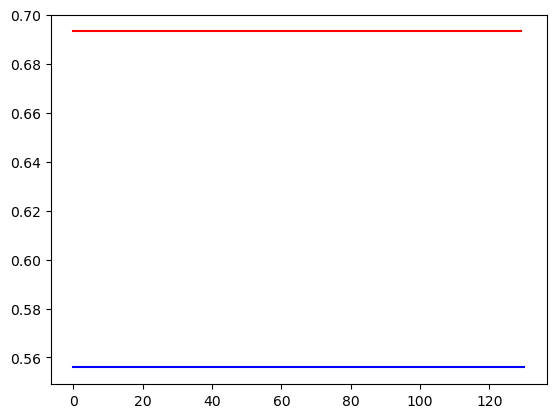

Testing Accuracy: 54.97%
Dataset weighting: 0.4503311258278146


0.5496688741721855

In [17]:
import matplotlib.pyplot as plt

plt.plot(tr, color="r")
plt.plot([i*10 for i in range(len(vr))], vr, color="b")
plt.show()

validate_model(model, test_loader, testing=True)

### Another exercise

**ESOL** is a regression dataset, predicting the solubility of various molecules. Adapt the above code for this dataset.

In [63]:
dataset = MoleculeNet("datasets/", "ESOL")
atom_dims = dataset.num_node_features
bond_dims = dataset.num_edge_features

# Convert dataset to a list of Data objects
data_list = list(dataset)
# Shuffle (these datasets have all the labels at one end)
random.shuffle(data_list)
dataset = data_list

train_prop, val_prop, test_prop = 0.6, 0.2, 0.2
n_train, n_val, n_test = int(train_prop*len(dataset)), int(val_prop*len(dataset)), int(test_prop*len(dataset))
train, val, test = dataset[:n_train], dataset[n_train:-n_test], dataset[-n_test:]
train_loader = DataLoader(train, batch_size = 64, shuffle = True)
val_loader = DataLoader(val, batch_size = 64, shuffle = True)
test_loader = DataLoader(test, batch_size = 64, shuffle = True)


Processing...
Done!
